In [3]:
import sys, os
sys.path.append(os.pardir)

In [1]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose
import plotly.express as px

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_train")

In [6]:
from src.utils.metrics import event_detection_ap
from src.utils.post_process import make_submission
from src.utils.common import trace
from src.utils.detect_peak import post_process_from_2nd



In [12]:
event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").drop_nulls()
event_df = event_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [14]:
sub = pl.read_csv('./submission.csv')
pred_df = pl.read_parquet('../data/sakami/009_cnn/valid_preds.parquet')
valid_sub =  pl.read_parquet('../data/sakami/009_cnn/valid_submission.parquet')

In [15]:
series_ids = sub['series_id'].unique().to_list()
len(series_ids)

200

In [18]:
score = event_detection_ap(
    event_df.filter(pl.col('series_id').is_in(series_ids)).to_pandas(),
    valid_sub.filter(pl.col('series_id').is_in(series_ids)).to_pandas(),
)
score

Matching detections to ground truth events:   0% 0/390 [00:00<?, ?it/s]

0.829488223589187

In [ ]:

sub_df = post_process_from_2nd(
    pred_df,
    daily_score_offset = params['daily_score_offset'],
)


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(data, filename="score.png"):
    # 統計値の計算
    mean = np.mean(data)
    median = np.median(data)
    min_val = np.min(data)
    max_val = np.max(data)
    std_dev = np.std(data)

    plt.hist(data, bins=10, alpha=0.7)
    plt.title(f"mean:{mean:.4}, median:{median:.4}, min:{min_val:.4}, max:{max_val:.4}, std:{std_dev:.4}")
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.savefig(filename)

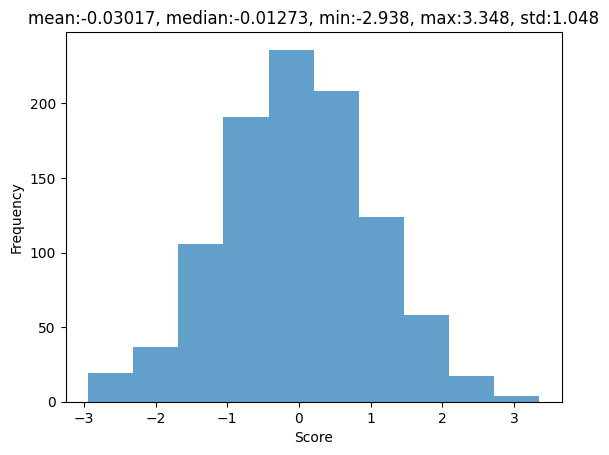

In [28]:
data = np.random.normal(0, 1, 1000)
plot_histogram(data)

In [3]:
import logging
from pathlib import Path
import polars as pl
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hydra
from omegaconf import DictConfig
from omegaconf import OmegaConf

from src.utils.metrics import event_detection_ap
from src.utils.chokudai_search import chokudai_search_from_2nd

In [8]:

def load_shimacos_pred(dir: Path):
    pred_df = (
        pl.read_parquet(dir / "pred_onset.parquet")
        .rename({"label_pred": "stacking_prediction_onset"})
        .drop("label")
        .join(
            pl.read_parquet(dir / "pred_wakeup.parquet").rename({"label_pred": "stacking_prediction_wakeup"}).drop("label"),
            on=["series_id", "step"],
            how="left",
        )
    )
    pred_df = pred_df.with_columns(
        ((pl.col("step") - pl.col("step").shift(1)) != 12)
        .cast(int)
        .cumsum()
        .over("series_id")
        .fill_null(0)
        .alias("chunk_id")
    ).with_columns(pl.col("step").cast(pl.UInt32))
    return pred_df

In [12]:
pred_df = load_shimacos_pred(Path('../data/shimacos/stacking_exp013_009_1minute_sampling/result'))


In [13]:
pred_df

series_id,step,stacking_prediction_onset,stacking_prediction_wakeup,chunk_id
str,u32,f64,f64,i64
"""038441c925bb""",0,0.000008,0.00001,0
"""038441c925bb""",12,0.000008,0.000008,0
"""038441c925bb""",24,0.000007,0.000031,0
"""038441c925bb""",36,0.000009,0.000019,0
"""038441c925bb""",48,0.000006,0.000007,0
"""038441c925bb""",60,0.000007,0.000005,0
"""038441c925bb""",72,0.000007,0.000006,0
"""038441c925bb""",84,0.000006,0.000006,0
"""038441c925bb""",96,0.000006,0.000005,0


In [15]:
base_df = pl.read_parquet("../data/009.parquet",columns=['series_id', 'step', 'timestamp'])
base_df

series_id,step,timestamp
str,i64,"datetime[μs, UTC]"
"""038441c925bb""",0,2018-08-14 19:30:00 UTC
"""038441c925bb""",12,2018-08-14 19:31:00 UTC
"""038441c925bb""",24,2018-08-14 19:32:00 UTC
"""038441c925bb""",36,2018-08-14 19:33:00 UTC
"""038441c925bb""",48,2018-08-14 19:34:00 UTC
"""038441c925bb""",60,2018-08-14 19:35:00 UTC
"""038441c925bb""",72,2018-08-14 19:36:00 UTC
"""038441c925bb""",84,2018-08-14 19:37:00 UTC
"""038441c925bb""",96,2018-08-14 19:38:00 UTC


In [18]:
pred_df = pl.concat([ pl.read_parquet("../data/009.parquet",columns=['series_id', 'step', 'timestamp']),
           pl.read_parquet("../data/sakami/004_transformer_category_padding_idx/valid_preds.parquet")
          ], how="horizontal")


In [19]:
pred_df

series_id,step,timestamp,row_id,stacking_prediction_onset,stacking_prediction_wakeup
str,i64,"datetime[μs, UTC]",i64,f32,f32
"""038441c925bb""",0,2018-08-14 19:30:00 UTC,0,0.000024,1.2125e-7
"""038441c925bb""",12,2018-08-14 19:31:00 UTC,1,0.00001,2.4939e-9
"""038441c925bb""",24,2018-08-14 19:32:00 UTC,2,4.3041e-7,2.0538e-8
"""038441c925bb""",36,2018-08-14 19:33:00 UTC,3,0.000027,6.2915e-8
"""038441c925bb""",48,2018-08-14 19:34:00 UTC,4,6.3560e-7,4.2752e-8
"""038441c925bb""",60,2018-08-14 19:35:00 UTC,5,0.000017,2.5683e-9
"""038441c925bb""",72,2018-08-14 19:36:00 UTC,6,0.000025,4.0242e-8
"""038441c925bb""",84,2018-08-14 19:37:00 UTC,7,0.000047,5.7438e-7
"""038441c925bb""",96,2018-08-14 19:38:00 UTC,8,0.000007,2.2604e-8


In [37]:
def load_shimacos_nn_pred(name: str):
    pred_df = (
        pl.concat(
            [
                pl.read_parquet(f"../data/shimacos/{name}/fold{i}/result/valid.parquet") for i in range(5)
            ],
            how="vertical"
        )
    ).with_columns(
            pl.col("step").cast(pl.UInt32)
    ).rename({
        "label_onset_pred": f"{name}_stacking_prediction_onset",
        "label_wakeup_pred": f"{name}_stacking_prediction_wakeup",
        })
    return pred_df

In [38]:
base_df = load_shimacos_nn_pred("stacking_exp030_021_chink_gru")
base_df

series_id,step,label_onset,label_wakeup,stacking_exp030_021_chink_gru_stacking_prediction_onset,stacking_exp030_021_chink_gru_stacking_prediction_wakeup,timestamp,chunk_id
str,u32,f64,f64,f64,f64,"datetime[μs, UTC]",i64
"""0402a003dae9""",2244,0.0,0.0,5.2036e-7,0.000335,2018-12-18 20:52:00 UTC,0
"""0402a003dae9""",2256,0.0,0.0,1.1979e-7,0.000005,2018-12-18 20:53:00 UTC,0
"""0402a003dae9""",2268,0.0,0.0,3.1250e-8,0.000001,2018-12-18 20:54:00 UTC,0
"""0402a003dae9""",2280,0.0,0.0,1.1677e-8,5.7477e-8,2018-12-18 20:55:00 UTC,0
"""0402a003dae9""",2292,0.0,0.0,3.0116e-7,3.5209e-7,2018-12-18 20:56:00 UTC,0
"""0402a003dae9""",2304,0.0,0.0,5.3688e-7,5.6264e-7,2018-12-18 20:57:00 UTC,0
"""0402a003dae9""",2316,0.0,0.0,8.6465e-7,8.7143e-7,2018-12-18 20:58:00 UTC,0
"""0402a003dae9""",2328,0.0,0.0,5.2951e-8,2.3091e-7,2018-12-18 20:59:00 UTC,0
"""0402a003dae9""",2340,0.0,0.0,1.1230e-8,7.8256e-8,2018-12-18 21:00:00 UTC,0


In [1]:
import optuna
import sklearn
import sklearn.datasets
import sklearn.linear_model


N_TRIALS_PER_WORKER = 100


def objective(trial):
    #  データのロードと分割
    wine = sklearn.datasets.load_wine()
    classes = list(set(wine.target))
    train_x, valid_x, train_y, valid_y = \
        sklearn.model_selection.train_test_split(wine.data, wine.target, test_size=0.25, random_state=0)

    #  ハイパーパラメータの決定とモデルオブジェクトの初期化
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    clf = sklearn.linear_model.SGDClassifier(alpha=alpha)

    # モデルの学習と評価
    clf.fit(train_x, train_y, classes=classes)

    return 1.0 - clf.score(valid_x, valid_y)

study = optuna.create_study(
    study_name="example-study", 
    storage='mysql://root@db/optuna',
    load_if_exists=True,
)
study.optimize(objective, n_trials=N_TRIALS_PER_WORKER)

print(f"このワーカーが終了した時点で最良の誤差: {study.best_value}")
print(f"このワーカーが終了した時点で最良のハイパーパラメータ: {study.best_params}")

[I 2023-12-04 02:57:43,012] A new study created in RDB with name: example-study
[W 2023-12-04 02:57:43,071] Trial 0 failed with parameters: {'alpha': 0.0007804690903810456} because of the following error: TypeError("BaseSGDClassifier.fit() got an unexpected keyword argument 'classes'").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_139/3065636688.py", line 22, in objective
    clf.fit(train_x, train_y, classes=classes)
TypeError: BaseSGDClassifier.fit() got an unexpected keyword argument 'classes'
[W 2023-12-04 02:57:43,072] Trial 0 failed with value None.


TypeError: BaseSGDClassifier.fit() got an unexpected keyword argument 'classes'